In [21]:
import logging ;logger = logging.getLogger(__name__); logging.basicConfig(level='INFO'); load('main.sage')

skmod = QuantumAPolynomial('4_1',pachner_moves=[{"tet":0,"face":3}])
skmod.compute_skein_module()

strip_q = lambda coord : vector([0] + list(coord)[1:])

new_basis = [skmod.gens_dict['qrt2'],strip_q(skmod.meridian),strip_q(skmod.longitude)]

for vec in skmod.monomial_relations:
    if strip_q(vec) not in span(new_basis):
        new_basis.append(strip_q(vec))
        
for vec in skmod.invariant_sublattice.basis():
    if strip_q(vec) not in span(new_basis):
        new_basis.append(strip_q(vec))

inv_lattice = skmod.invariant_sublattice.submodule_with_basis(new_basis)

restricted_omega = inv_lattice.basis_matrix()*skmod.omega_with_q*(inv_lattice.basis_matrix().transpose())

# this is horrible but change the behavior here:
FLAG_inverses_last=True

if FLAG_inverses_last:
    # here all the originals first then all the inverses
    doubled_res_omega = Matrix.block([[restricted_omega[1:,1:],-restricted_omega[1:,1:]],[-restricted_omega[1:,1:],restricted_omega[1:,1:]]])
else:
    # here its M, Mi, L, Li, x1, xi1,...
    doubled_res_omega = matrix(restricted_omega[1:,1:].tensor_product(matrix([[1,-1],[-1,1]])))

INFO:__main__:A-polynomial for 4_1:	M^14*L - M^12*L - M^10*L^2 - 2*M^10*L + M^10 + M^8*L^2 + 5*M^8*L + 5*M^6*L^2 + M^6*L + M^4*L^3 - 2*M^4*L^2 - M^4*L - M^2*L^2 + L^2
ERROR:__main__:Our A-polynomial has a complicated relationship with the reference one!


Defining qrt2, M, L, w0, w1, w0i, w1i


55 x 91 dense matrix over Rational Field (use the '.str()' method to see the entries)

In [ ]:
# quotient by invariant functions:
central_relations = []
for rel in skmod.monomial_relations:
    if inv_lattice.basis_matrix()*skmod.omega_with_q*rel == 0:
        central_relations.append(rel)
        
small_lattice = inv_lattice.quotient(central_relations)

pi = small_lattice.coerce_map_from(small_lattice.V())

new_small_basis = [pi(skmod.gens_dict['qrt2']),pi(skmod.meridian),pi(skmod.longitude)]
for vec in small_lattice.gens():
    if vec not in small_lattice.submodule(new_small_basis):
        new_small_basis.append(vec)

In [ ]:
small_basis_lift = matrix([g.lift() for g in new_small_basis])
small_basis_lift
small_restricted_omega = small_basis_lift*skmod.omega_with_q*(small_basis_lift.transpose())
small_restricted_omega

small_doubled_res_omega = Matrix.block([[small_restricted_omega[1:,1:],-small_restricted_omega[1:,1:]],[-small_restricted_omega[1:,1:],small_restricted_omega[1:,1:]]])

# Helper Functions

In [12]:
# 1-indexed:
kth_coord = lambda k,coord: vector((k-1)*[0] + [coord[k-1]] + (len(coord)-k)*[0])


def get_doubled_lattice_coord(coord,inverses_last=FLAG_inverses_last):
    """
    Assumes the first coordinate is q, which can be negative and shouldn't be doubled
    ex: inverses_last = True means
    ( 1, a,b) -> ( 1,a,b,0,0)
    (-1,-a,b) -> (-1,0,b,a,0)
    
    inverses_last = False means:
    ( 1, a,b)-> ( 1,a,0,b,0)
    (-1,-a,b) -> (-1,0,a,b,0)
    """
    
    pos = vector([max(coord[i],0) for i in range(1,len(coord))])
    neg = vector([min(coord[i],0) for i in range(1,len(coord))])
    if inverses_last:
        return [coord[0]] + list(pos) + list(-1*neg)
    else:
        return  [coord[0]]+flatten([[list(pos)[i],list(-1*neg)[i]] for i in range(len(pos))])
         


def get_free_alg_element_from_coord(coord,basis_matrix,omega,free_alg,qq_override_value=False):
    """
    Assumes the coordinate is for the skein algebra, i.e. has q as the first coordinate and needs to be doubled to deal with inverses
    
    Parameters:
    coord vector
    basis_matrix matrix - the basis for the invariant sublattice
    free_alg free_algebra
    qq_override_value (default: False) - if this is set then override the default value (q) for qq
    """
    conversion_q_factor = normal_to_lex_q_power(coord,omega)*vector([1]+(len(coord)-1)*[0])
    doubled_coord = get_doubled_lattice_coord(basis_matrix.solve_left(conversion_q_factor+coord))
    if qq_override_value:
        qq = qq_override_value
    else:
        qq = free_alg.base().gen()
        
    without_q = '*'.join([
        '{0}^({1})'.format(free_alg.gen(i),doubled_coord[i])
        for i in range(1,len(doubled_coord)-1) if doubled_coord[i] != 0
    ])        
    return qq^doubled_coord[0]*free_alg(without_q)
    
def get_scaling(coord,omega):
    upper_triangular_omega = zero_matrix(*omega.dimensions())
    for j in range(omega.nrows()):
        for i in range(omega.ncols()):
            if i <= j:
                upper_triangular_omega[i,j] = omega[i,j]
         
    scaling = (1/2)*(matrix(coord)*upper_triangular_omega*(matrix(coord).transpose()))[0,0]
    second_version = (-1)*sum(flatten([
        [
            coord[i]*coord[j]*omega[i,j] for i in range(j-1)
        ] for j in range(len(coord))
    ]))
    #print("first version: ",scaling,"\t, second version: ",second_version)
    return second_version


def get_g_alg_element_from_coord(coord,basis_matrix,omega,g_alg,qq_override_value=False):
    """
    Assumes the coordinate is for the skein algebra, i.e. has q as the first coordinate and needs to be doubled to deal with inverses
    
    Parameters:
    coord vector
    basis_matrix matrix - the basis for the invariant sublattice
    g_alg g_algebra
    qq_override_value (default: False) - if this is set then override the default value (q) for qq
    """
 
    #logger.info("coord: {}".format(coord))
    #logger.info("doubled_coord: {}".format(doubled_coord))
    #logger.debug("ngens: {0}, double_coord length:{1}".format(g_alg.ngens(),len(doubled_coord)))
    omega_restriction = basis_matrix*omega*basis_matrix.transpose()
    inv_coord = basis_matrix.solve_left(coord)
    
    conversion_q_factor = get_scaling(inv_coord,omega_restriction)
    conversion_vector = vector([conversion_q_factor]+[0]*(len(coord)-1))
    doubled_coord = get_doubled_lattice_coord(basis_matrix.solve_left(conversion_vector + coord))
    if qq_override_value:
        qq = qq_override_value
    else:
        qq = g_alg.base().gen()
        
    free_alg = g_alg.free_algebra()
    # make the monomial as a string:
    without_q = '*'.join([
        '{0}^({1})'.format(g_alg.gen(i-1),doubled_coord[i])
        for i in range(1,len(doubled_coord)) if doubled_coord[i] != 0
    ])
    #logger.info("without_q: {}".format(without_q))
    return qq^doubled_coord[0]*g_alg(free_alg(without_q))

#get_free_alg_element_from_coord(inv_lattice.basis_matrix()*skmod.monomial_relations[1],A2)

### Debugging

In [13]:
to_inv = lambda c : inv_lattice.basis_matrix().solve_left(c)
print("We expect a(c1)+a(c2)-a(c1+c2) = 1/2*omega(c1,c2)")

randomish_vector = lambda combo,basis: sum([combo[i]*basis[i] for i in range(len(combo))])

r1 = randomish_vector(vector((0,1,1,1,0,2,0,1,1,0,0)),inv_lattice.basis())
r2 = randomish_vector((0,1,0,0,1,1,0,0,0,0,0,0,0,0,0),inv_lattice.basis())

print("a(r1) = ",get_scaling(to_inv(r1),restricted_omega), ",\t a(r2) = ", get_scaling(to_inv(r2),restricted_omega), ",\t a(r1+r2) = ",get_scaling(to_inv(r1+r2),restricted_omega))
print("a(r1)+a(r2)-a(r1+r2) = \t", get_scaling(to_inv(r1),restricted_omega)+get_scaling(to_inv(r2),restricted_omega)-get_scaling(to_inv(r1+r2),restricted_omega))
print("1/2*omega(c1,c2) = \t", (1/2)*(r1*skmod.omega_with_q*matrix(r2).transpose())[0])
print("\n\n")

print("without q:")
print("a(r1) = ",get_scaling(to_inv(r1)[1:],restricted_omega[1:,1:]), ",\t a(r2) = ", get_scaling(to_inv(r2)[1:],restricted_omega[1:,1:]), ",\t a(r1+r2) = ",get_scaling(to_inv(r1+r2)[1:],restricted_omega[1:,1:]))
print("a(r1)+a(r2)-a(r1+r2) = \t", get_scaling(to_inv(r1)[1:],restricted_omega[1:,1:])+get_scaling(to_inv(r2)[1:],restricted_omega[1:,1:])-get_scaling(to_inv(r1+r2)[1:],restricted_omega[1:,1:]))
print("1/2*omega(c1,c2) = \t", (1/2)*(r1*skmod.omega_with_q*matrix(r2).transpose())[0])
print("\n\n")

if True:
    import itertools
    for c1,c2 in itertools.combinations(inv_lattice.basis()[1:10],2):
        s1 = get_scaling(to_inv(c1),restricted_omega)
        s2 = get_scaling(to_inv(c2),restricted_omega)
        s12 = get_scaling(to_inv(c1+c2),restricted_omega)
        #print("a(c1):",s1,"a(c2):",s2,"a(c1+c2):",s12)
        #print("pairing c1,c2:", c1*skmod.omega_with_q*matrix(c2).transpose())
        print("a(c1)+a(c2)-a(c1+c2) = \t",s1+s2-s12)
        print("1/2*omega(c1,c2) = \t",(1/2)*(to_inv(c1)*restricted_omega*matrix(to_inv(c2)).transpose())[0])
       # print("omega(c1,c2) = \t",c1*skmod.omega_with_q*matrix(c2).transpose())
        print()

We expect a(c1)+a(c2)-a(c1+c2) = 1/2*omega(c1,c2)
a(r1) =  0 ,	 a(r2) =  0 ,	 a(r1+r2) =  0
a(r1)+a(r2)-a(r1+r2) = 	 0
1/2*omega(c1,c2) = 	 -1/2



without q:
a(r1) =  0 ,	 a(r2) =  0 ,	 a(r1+r2) =  0
a(r1)+a(r2)-a(r1+r2) = 	 0
1/2*omega(c1,c2) = 	 -1/2



a(c1)+a(c2)-a(c1+c2) = 	 0
1/2*omega(c1,c2) = 	 1/2

a(c1)+a(c2)-a(c1+c2) = 	 0
1/2*omega(c1,c2) = 	 0

a(c1)+a(c2)-a(c1+c2) = 	 0
1/2*omega(c1,c2) = 	 0

a(c1)+a(c2)-a(c1+c2) = 	 0
1/2*omega(c1,c2) = 	 0

a(c1)+a(c2)-a(c1+c2) = 	 0
1/2*omega(c1,c2) = 	 0

a(c1)+a(c2)-a(c1+c2) = 	 0
1/2*omega(c1,c2) = 	 0

a(c1)+a(c2)-a(c1+c2) = 	 0
1/2*omega(c1,c2) = 	 0

a(c1)+a(c2)-a(c1+c2) = 	 0
1/2*omega(c1,c2) = 	 0

a(c1)+a(c2)-a(c1+c2) = 	 0
1/2*omega(c1,c2) = 	 0

a(c1)+a(c2)-a(c1+c2) = 	 0
1/2*omega(c1,c2) = 	 0

a(c1)+a(c2)-a(c1+c2) = 	 0
1/2*omega(c1,c2) = 	 0

a(c1)+a(c2)-a(c1+c2) = 	 0
1/2*omega(c1,c2) = 	 0

a(c1)+a(c2)-a(c1+c2) = 	 0
1/2*omega(c1,c2) = 	 0

a(c1)+a(c2)-a(c1+c2) = 	 0
1/2*omega(c1,c2) = 	 0

a(c1)+a(c2)-a(c1+c2) = 	 0


In [ ]:
#print(get_g_alg_element_from_coord(L_coord+M_coord,inv_lattice.basis_matrix(),skmod.omega_with_q,H2))
#print(get_g_alg_element_from_coord(M_coord,inv_lattice.basis_matrix(),skmod.omega_with_q,H2))
#print(get_g_alg_element_from_coord(L_coord,inv_lattice.basis_matrix(),skmod.omega_with_q,H2))
#print("\n")
#print(L_coord*skmod.omega_with_q*matrix(M_coord).transpose())
#print(L*M)

import itertools
for coord1,coord2 in itertools.combinations(inv_lattice.basis()[1:5],2):
    #print(get_scaling(coord,skmod.omega_with_q))
    elem1 = get_g_alg_element_from_coord(coord1,inv_lattice.basis_matrix(),skmod.omega_with_q,H2)
    elem2 = get_g_alg_element_from_coord(coord2,inv_lattice.basis_matrix(),skmod.omega_with_q,H2)
    together = get_g_alg_element_from_coord(coord1+coord2,inv_lattice.basis_matrix(),skmod.omega_with_q,H2)
    print(" c1: ",elem1,",\n c2: ",elem2)
    print("c1+c2: ",together)
    print(elem1.monomials()[0]*elem2.monomials()[0], " vs ",elem2.monomials()[0]*elem1.monomials()[0])
    print(coord1*skmod.omega_with_q*matrix(coord2).transpose())
    print("\n")



In [ ]:
import itertools
for c1,c2,c3,c4 in itertools.combinations(inv_lattice.basis()[1:11],4):
    #print(get_scaling(coord,skmod.omega_with_q))
    elem1 = get_g_alg_element_from_coord(c1,inv_lattice.basis_matrix(),skmod.omega_with_q,H2)
    elem2 = get_g_alg_element_from_coord(c2,inv_lattice.basis_matrix(),skmod.omega_with_q,H2)
    elem3 = get_g_alg_element_from_coord(c3,inv_lattice.basis_matrix(),skmod.omega_with_q,H2)
    together = get_g_alg_element_from_coord(c1+c2+c3,inv_lattice.basis_matrix(),skmod.omega_with_q,H2)
    print(" c1: ",elem1,",\n c2: ",elem2,"\n c3: ",elem3)
    print("c1+c2 times c3:",get_g_alg_element_from_coord(c1+c2,inv_lattice.basis_matrix(),skmod.omega_with_q,H2)*get_g_alg_element_from_coord(c3,inv_lattice.basis_matrix(),skmod.omega_with_q,H2))
    print("c3 times c1+c2:",get_g_alg_element_from_coord(c3,inv_lattice.basis_matrix(),skmod.omega_with_q,H2)*get_g_alg_element_from_coord(c1+c2,inv_lattice.basis_matrix(),skmod.omega_with_q,H2))
    print((c1+c2)*skmod.omega_with_q*matrix(c3).transpose())
    print("\n")

In [ ]:
first_random = 2*inv_lattice.basis()[2]+inv_lattice.basis()[5]+2*inv_lattice.basis()[8]
second_random = inv_lattice.basis()[1]+2*inv_lattice.basis()[3]+inv_lattice()[7]+2*inv_lattice()[11]
elem1 = get_g_alg_element_from_coord(first_random,inv_lattice.basis_matrix(),skmod.omega_with_q,H2)
elem2 = get_g_alg_element_from_coord(second_random,inv_lattice.basis_matrix(),skmod.omega_with_q,H2)
together = get_g_alg_element_from_coord(first_random+second_random,inv_lattice.basis_matrix(),skmod.omega_with_q,H2)
print("first:",elem1,"second:",elem2)
print("together:",together)
print(elem1*elem2," vs ",elem2*elem1)
print(get_scaling(inv_lattice.basis_matrix().solve_left(first_random),restricted_omega),get_scaling(inv_lattice.basis_matrix().solve_left(second_random),restricted_omega),get_scaling(inv_lattice.basis_matrix().solve_left(first_random+second_random),restricted_omega))

In [ ]:
get_g_alg_element_from_coord(new_basis[3],inv_lattice.basis_matrix(),skmod.omega_with_q,H2)

### More helper functions

In [14]:
# Functions to get the skein algebra name for an element of the g_algebra
#TODO - get all the coordinates straight! It's a mix of the FA and the skalg. @_@

def get_folded_coordinate(coord,inverses_last=FLAG_inverses_last):
    """
    Assumes the first coordinate is q, which can be negative and shouldn't be doubled.
     
     Parameters:
     coord Vector, List - the coordinate, should have length 1 + the rank of the free algebra
     inverses_last=FLAG_inverses_last - if true it assumes (q,x1,x2,xi1,xi2), if false then (q,x1,xi1,x2,xi2)
     
     Output:
     vector -- the coordinate converted to the dimension of the invariant lattice.
     
    """
    l = len(coord)
    l_coord = list(coord)
    if inverses_last:
        return vector(l_coord[:(l+1)/2]) - vector([0]+l_coord[(l+1)/2:])
    else:
        return vector([l_coord[0]] + [l_coord[i]-l_coord[i+1] for i in range(1,l-1,2)])
    

def get_coord_from_g_alg(element,free_alg_gens_dict,fold=True):
    """
    Changes a monomial in a g_algebra to a coordinate of length 1+free_algebra.ngens() or 1+ free_algebra.ngens()/2
    This output will be in the basis for the invariant lattice.
    """
    q_pow_lambda = lambda s : '-'+s.split('^')[-1].strip(')') if s.startswith('1/') else s.split('^')[-1].strip(')')
    x_pow_lambda = lambda x : 1 if x.count('^') == 0 else int(x.split('^')[-1].strip(')'))
                                                                                                                       
    FA = element.parent().free_algebra()
    coord_length = len(list(free_alg_gens_dict.values())[0])
    if len(element.monomials()) > 1:
        print("Only monomials have coordinates!")
        return None
    
    str_list = str(element).split('*')
    x_vars = list(element.exponents()[0])
    #x_vars = [vector([0]+list(x_pow_lambda(v)*vector(free_alg_gens_dict[FA(v.split('^')[0])]))) for v in str_list if ['x','L','M'].count(v[0]) == 1]
    # both q and 1/q should be replaced by 1, since we add a - when there's a 1/ in the string
    scalars = sum([int(q_pow_lambda(v).replace('1/q','1').replace('q','1').replace('--','')) for v in str_list if ['x','L','M'].count(v[0]) == 0 ])
    return get_folded_coordinate([scalars]+x_vars) if fold else vector([scalars]+x_vars)
    
def get_skalg_name_from_g_alg(element,inv_lattice_basis_matrix,free_alg_gens_dict,gens_dict):
    return QuantumAPolynomial.lattice_coord_to_dict(inv_lattice_basis_matrix.transpose()*get_coord_from_g_alg(element,free_alg_gens_dict),gens_dict)

# Checks

In [ ]:
# These should agree:
print(inv_lattice.basis_matrix().transpose()*get_coord_from_g_alg(get_g_alg_element_from_coord(skmod.monomial_relations[3],inv_lattice.basis_matrix(),skmod.omega_with_q,H2),FA_gens_dict))
print(skmod.monomial_relations[3])

In [ ]:
H2.ideal(thread_monodromy_relations+puncture_monodromy_relations+short_edge_gluing_relations).std().gens()
for a in short_edge_gluing_relations+puncture_monodromy_relations+thread_monodromy_relations:
    for b in H2.gens():
        if a*b != b*a:
            print(a,b)

In [ ]:
# DEBUGGING - check that long edges always show up in pairs.
for elem in inv_lattice.basis():
    elem_dict = QuantumAPolynomial.lattice_coord_to_dict(elem,skmod.gens_dict)
    #print({k:v for k,v in elem_dict.items() if k[0] == 'A'})

# list out the non-central relations
for rel in skmod.monomial_relations:
    if inv_lattice.basis_matrix()*skmod.omega_with_q*rel != 0:
        print(QuantumAPolynomial.lattice_coord_to_dict(rel,skmod.gens_dict))

# show the commutation relations matrix
show(plot(doubled_res_omega))
doubled_res_omega.is_skew_symmetric()

# Set up g_algebra

In [22]:
S = FractionField(QQ['q'])
q = S.gen()
#A.<x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36> = FreeAlgebra(S,36)

dim_wo_q = inv_lattice.dimension()-1
# order M,L,x1,...,Mi,Li,xi1,...
A2 = FreeAlgebra(S,2*dim_wo_q,['M','L'] + ['x{}'.format(i) for i in range(1,dim_wo_q-2+1)]+['Mi','Li']+['xi{}'.format(i) for i in range(1,dim_wo_q-2+1)])

# order M, Mi, L, Li, x1, xi1, ...
#A2 = FreeAlgebra(S,2*dim_wo_q,['M','Mi','L','Li'] + flatten([['x{}'.format(i),'xi{}'.format(i)] for i in range(1,dim_wo_q-2+1)]))
FA_gens_dict = {A2.gen(i) : [0]*(i) + [1] + [0]*(2*dim_wo_q-i-1) for i in range(A2.ngens())}

import itertools
relations_FA = {}
for g2,g1 in itertools.combinations(FA_gens_dict.keys(),2):
    #print(matrix(x_gens_dict[g1])*(restricted_omega*(matrix(x_gens_dict[g2]).transpose())))
    power = 2*(matrix(FA_gens_dict[g2])*doubled_res_omega*(matrix(FA_gens_dict[g1]).transpose()))[0][0]
    if power != 0:
        this_rel = [g1*g2,q**int(power)*g2*g1]
        #print(this_rel)
        #this_rel.sort(reverse=True)
        relations_FA[this_rel[0]] = this_rel[1]
        

# these relations aren't the right shape for a g_algebra
#central_relations_FA = {}
#for rel in skmod.monomial_relations:
#    if inv_lattice.basis_matrix()*skmod.omega_with_q*rel == 0:
#        print(QuantumAPolynomial.lattice_coord_to_dict(rel,skmod.gens_dict))
#        print(get_free_alg_element_from_coord(rel,A2))
#        central_relations_FA[get_free_alg_element_from_coord(rel,A2)] = A2('1')
        
#relations_FA.update(central_relations_FA)

H2 = A2.g_algebra(relations_FA)
H2.inject_variables()

Defining M, L, x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12, x13, x14, x15, x16, x17, x18, x19, x20, x21, x22, x23, x24, x25, x26, x27, x28, x29, x30, x31, x32, x33, x34, x35, x36, x37, x38, x39, x40, x41, x42, x43, x44, x45, x46, x47, x48, x49, x50, x51, x52, Mi, Li, xi1, xi2, xi3, xi4, xi5, xi6, xi7, xi8, xi9, xi10, xi11, xi12, xi13, xi14, xi15, xi16, xi17, xi18, xi19, xi20, xi21, xi22, xi23, xi24, xi25, xi26, xi27, xi28, xi29, xi30, xi31, xi32, xi33, xi34, xi35, xi36, xi37, xi38, xi39, xi40, xi41, xi42, xi43, xi44, xi45, xi46, xi47, xi48, xi49, xi50, xi51, xi52


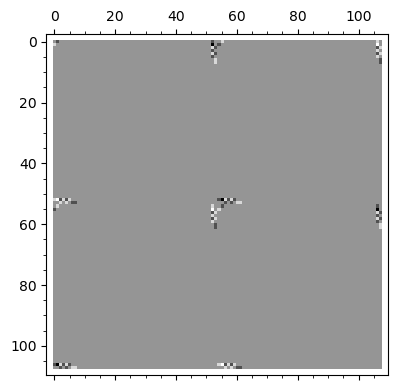

In [23]:
matrix_plot(doubled_res_omega)
#QuantumAPolynomial.lattice_coord_to_ring_element(bm.solve_left(skmod.monomial_relations[0]),H2,restricted_omega)

#(list(bm.solve_left(skmod.monomial_relations[0])))

### Get relations into g_algebra

In [24]:

monomial_relations = [get_g_alg_element_from_coord(c,inv_lattice.basis_matrix(),skmod.omega_with_q,H2)-1 for c in skmod.monomial_relations]


crossing_rel = [
    reduce(H2.summation,
           [-1]+[
               get_g_alg_element_from_coord(mon,inv_lattice.basis_matrix(),skmod.omega_with_q,H2)
               for mon in relation]
          ) for relation in skmod.crossing_relations]
inverses_relations = [M*Mi-1,L*Li-1]+[H2(A2('x{0}*xi{1}'.format(j,j)))-1 for j in range(1,dim_wo_q-2+1)]

relations_ideal = H2.ideal(monomial_relations + crossing_rel+inverses_relations)

x_vars = [g for name,g in H2.gens_dict().items() if name[0]=='x']


In [25]:
# check - is the elimination ideal wrong?
relations_ideal.elimination_ideal([x1]).gens()

(1,)

In [26]:
print(skmod.monomial_relations[0])
print(get_g_alg_element_from_coord(skmod.monomial_relations[0],inv_lattice.basis_matrix(),skmod.omega_with_q,H2))

(-9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0)
1/(q^9)*x1


In [ ]:
# little check: the commutation relation agrees on M and L:
print(matrix(skmod.longitude)*skmod.omega_with_q*(matrix(skmod.meridian).transpose()))
print(M*L == L*M)

# what is the meridian?
print(get_skalg_name_from_g_alg(M,inv_lattice.basis_matrix(),FA_gens_dict,skmod.gens_dict))
#QuantumAPolynomial.lattice_coord_to_dict(inv_lattice.basis_matrix().transpose()*get_coord_from_g_alg(M,fold=True),skmod.gens_dict)

# set up g algebra with the quotient lattice

In [ ]:
small_dim_wo_q = small_lattice.ngens()-1
A = FreeAlgebra(S,2*small_dim_wo_q,['M','L'] + ['x{}'.format(i) for i in range(1,small_dim_wo_q-2+1)]+['Mi','Li']+['xi{}'.format(i) for i in range(1,small_dim_wo_q-2+1)])
small_FA_gens_dict = {A.gen(i) : [0]*(i) + [1] + [0]*(2*small_dim_wo_q-i-1) for i in range(A.ngens())}

import itertools
small_relations_FA = {}
for g2,g1 in itertools.combinations(small_FA_gens_dict.keys(),2):
    #print(matrix(x_gens_dict[g1])*(restricted_omega*(matrix(x_gens_dict[g2]).transpose())))
    power = (matrix(small_FA_gens_dict[g2])*small_doubled_res_omega*(matrix(small_FA_gens_dict[g1]).transpose()))[0][0]
    if power != 0:
        this_rel = [g1*g2,q**int(-power)*g2*g1]
        #print(this_rel)
        #this_rel.sort(reverse=True)
        small_relations_FA[this_rel[0]] = this_rel[1]
        
H = A.g_algebra(small_relations_FA)

In [ ]:
H.inject_variables()

### Get relations into g_algebra

In [ ]:
non_central_relations = []
for rel in skmod.monomial_relations:
    if inv_lattice.basis_matrix()*skmod.omega_with_q*rel != 0:
        non_central_relations.append(pi(rel))
        
small_monomial_relations = [
    get_g_alg_element_from_coord(vector(c),matrix(new_small_basis),small_restricted_omega,H)-1 for c in non_central_relations
]

small_crossing_rel = [
    reduce(H.summation,
           [-1]+[
               get_g_alg_element_from_coord(vector(pi(mon)),matrix(new_small_basis),small_restricted_omega,H)
               for mon in relation]
          ) for relation in skmod.crossing_relations]
small_inverses_relations = [M*Mi-1,L*Li-1]+[H(A('x{0}*xi{1}'.format(j,j)))-1 for j in range(1,small_dim_wo_q-2+1)]

small_relations_ideal = H.ideal(small_monomial_relations+small_inverses_relations)

In [ ]:
small_relations_ideal.std()

In [ ]:
# check if any of the thread monodromies are fine:
small_monomial_relations
for mon_relation in small_monomial_relations:
    test_ideal = H.ideal(small_crossing_rel+[mon_relation])
    if test_ideal.std().gens().count(1) > 0:
        print(mon_relation)
        
print("\n GB for crossing+inverses relations ideal:", H.ideal(small_crossing_rel+small_inverses_relations).std().gens())
print("\n GB for monomial relations+inverses ideal:", H.ideal(small_monomial_relations+small_inverses_relations).std().gens())

# Debug full elimination ideal.

In [ ]:
build_up_rel = []
for rel in monomial_relations + crossing_rel:
    build_up_rel.append(rel)
    tmp_elim_ideal = H2.ideal(build_up_rel).elimination_ideal([g for name,g in H2.gens_dict().items() if name[0]=='x'])
    if tmp_elim_ideal.gens().count(1) != 0:
        print("Adding {} broke the ideal!".format(rel))
        build_up_rel.remove(rel)
        #break

In [27]:
# test all pairs of relations
all_sus_variables = []
all_sus_pairs = []
all_maybe_fine_variables = []
x_vars = [g for name,g in H2.gens_dict().items() if name[0]=='x']

linear_combo = lambda r1, r2: r1.coefficient(r1.monomials()[0])*r2.monomials()[0]*r1 + r2 

for pair in itertools.combinations(monomial_relations+crossing_rel,2):
    small_elimination_ideal = H2.ideal(pair).elimination_ideal(x_vars)
    if small_elimination_ideal.gens().count(1) != 0:
        rel1,rel2 = pair
        print(rel1,"\t",rel2)
        lc12 = linear_combo(rel1,rel2)
        lc21 = linear_combo(rel2,rel1)
        #print("BAD: ", lc12.coefficient(lc12.monomials()[0]), " vs ",lc21.coefficient(lc21.monomials()[0]))
        for rel in pair:
            for mon in rel.monomials():
                all_sus_variables += A2(str(mon)).variables()
        
    else:
        rel1,rel2 = pair
        lc12 = linear_combo(rel1,rel2)
        lc21 = linear_combo(rel2,rel1)
        coeff12 = lc12.coefficient(lc12.monomials()[0])
        coeff21 = lc21.coefficient(lc21.monomials()[0])
        #if coeff12 == coeff21:
        #print("OKAY: ",coeff12 , " vs ",coeff21)
        #else:
        #    print("OKAY: ", (coeff12, lc12.constant_coefficient())," vs ",(coeff21,lc21.constant_coefficient()))
        for rel in pair:
            for mon in rel.monomials():
                all_maybe_fine_variables += A2(str(mon)).variables()
        #print("ZERO:  ",monomial_relations[i:i+2])

sus_set = set(all_sus_variables)
maybe_okay_set = set(all_maybe_fine_variables)
print("sus: ",sus_set)
print("maybe okay: ", maybe_okay_set)
print("intersection: ", sus_set.intersection(maybe_okay_set))
print("only in okay: ",maybe_okay_set.difference(sus_set))
print("only in sus: ",sus_set.difference(maybe_okay_set))

1/(q^9)*x1 - 1 	 1/(q^4)*M^2*x7^2*x9*x10*x16^2*x19*x20*x21^2*x22^2*x24^2*x29*x30*x32*x38*x51^2*x52*Li*xi1*xi3*xi6*xi8*xi27*xi36^2*xi40^2*xi41*xi42^2*xi44^2*xi47^2*xi48^2 + 1/(q^3)*M^2*x4*x5*x7*x16*x21^2*x22*x24*x28*x29*x30*x33*x38*x41*x43*x45*x49*x50*x51^2*Li*xi3*xi8*xi11*xi13*xi14*xi17*xi20*xi23*xi27*xi36^2*xi37*xi42*xi44*xi47*xi48 - 1
1/(q^9)*x1 - 1 	 1/q*L*x2*x3^2*x4*x5*x6*x33*x37*x40*x41*x42*x43*x44^2*x45*x46^2*x47^2*x48^2*x49*Mi^4*xi7*xi8*xi9*xi10*xi11*xi12*xi13*xi16^2*xi18^2*xi19*xi20*xi21*xi22^2*xi23*xi24*xi25*xi26*xi28^2*xi30^2*xi34*xi35*xi51 + 1/(q^4)*L*x3^2*x9*x11*x14*x17*x20*x27*x32*x36*x37*x42*x44*x48*x52*Mi^2*xi1*xi4*xi7*xi10*xi16*xi21*xi22*xi26*xi28^2*xi30^2*xi31*xi34*xi38*xi41*xi45*xi50*xi51 - 1
1/(q^9)*x1 - 1 	 q*M^2*x8^2*x9*x11*x12^2*x13^2*x14*x16*x17*x18^2*x20*x23*x24*x25*x28*x30*x34*x36*x39*xi2^2*xi3*xi4*xi5*xi33*xi37*xi38*xi41*xi43^2*xi45*xi46^2*xi47*xi49*xi50*xi51 + 1/(q^4)*x1*x3*x6*x14*x25*x39*x42*x44*x52*xi7*xi10*xi15*xi21*xi22*xi33*xi50*xi51 - 1
1/(q^6)*x2 - 1 	

In [ ]:
## Do it again but with all n-tuples of relations.

all_sus_variables = []
all_sus_pairs = []
all_maybe_fine_variables = []
x_vars = [g for name,g in H2.gens_dict().items() if name[0]=='x']
linear_combo = lambda r1, r2: r1.coefficient(r1.monomials()[0])*r2.monomials()[0]*r1 + r2 

for small_batch in itertools.combinations(monomial_relations,5):
    small_elimination_ideal = H2.ideal(small_batch).elimination_ideal(x_vars)
    if small_elimination_ideal.gens().count(1) != 0:
        print("BAD! ",small_batch)
        for rel in small_batch:
            for mon in rel.monomials():
                all_sus_variables += A2(str(mon)).variables()
        
    else:
        for rel in small_batch:
            for mon in rel.monomials():
                all_maybe_fine_variables += A2(str(mon)).variables()

sus_set = set(all_sus_variables)
maybe_okay_set = set(all_maybe_fine_variables)
print("sus: ",sus_set)
print("maybe okay: ", maybe_okay_set)
print("intersection: ", sus_set.intersection(maybe_okay_set))
print("only in okay: ",maybe_okay_set.difference(sus_set))
print("only in sus: ",sus_set.difference(maybe_okay_set))

In [28]:

# test just the thread monodromies
print("\n Thread monodromy!")
thread_monodromy_in_skmod = [QuantumAPolynomial.names_to_lattice_coordinate(rel,skmod.gens_dict) for rel in QuantumAPolynomial.get_internal_edge_monodromy(skmod.gens_dict)]
thread_monodromy_relations = [get_g_alg_element_from_coord(c,inv_lattice.basis_matrix(),skmod.omega_with_q,H2)-1 for c in thread_monodromy_in_skmod]
print("relations:", thread_monodromy_relations)

print("elimination ideal: ",H2.ideal(thread_monodromy_relations).elimination_ideal(x_vars).gens())

# test just the puncture monodromies:
print("\n Puncture monodromy!")
puncture_monodromy_in_skmod = [QuantumAPolynomial.names_to_lattice_coordinate(rel,skmod.gens_dict) for rel in QuantumAPolynomial.get_T_monodromy_list(skmod.knot_comp,skmod.gens_dict)]
puncture_monodromy_relations = [get_g_alg_element_from_coord(c,inv_lattice.basis_matrix(),skmod.omega_with_q,H2)-1 for c in puncture_monodromy_in_skmod]
print("relations:", puncture_monodromy_relations)

print("elimination ideal: ",H2.ideal(puncture_monodromy_relations).elimination_ideal(x_vars).gens())

# test just the short edge gluing relations
print("\n Short edge gluing:")
short_edge_in_skmod = [QuantumAPolynomial.names_to_lattice_coordinate(rel,skmod.gens_dict) for rel in skmod.short_edge_gluing_relations_list]
short_edge_gluing_relations = [get_g_alg_element_from_coord(QuantumAPolynomial.names_to_lattice_coordinate(c,skmod.gens_dict),inv_lattice.basis_matrix(),skmod.omega_with_q,H2)-1 for c in skmod.short_edge_gluing_relations_list]
print("relations:", short_edge_gluing_relations)

print("elimination ideal: ",H2.ideal(short_edge_gluing_relations).elimination_ideal(x_vars).gens())

#test just the crossing relations
print("\n crossing:")
print("relations: ",crossing_rel)
print("elimination ideal: ",H2.ideal(crossing_rel).elimination_ideal(x_vars).gens())

#test just the long edge gluing relations:
print("\n Long edge gluing:")
long_edge_in_skmod = [QuantumAPolynomial.names_to_lattice_coordinate(rel,skmod.gens_dict) for rel in skmod.long_edge_gluing_relations_list]
long_edge_gluing_relations = [get_g_alg_element_from_coord(QuantumAPolynomial.names_to_lattice_coordinate(c,skmod.gens_dict),inv_lattice.basis_matrix(),skmod.omega_with_q,H2)-1 for c in skmod.long_edge_gluing_relations_list]
print("relations:", long_edge_gluing_relations)

print("elimination ideal: ",H2.ideal(long_edge_gluing_relations).elimination_ideal(x_vars).gens())


 Thread monodromy!
relations: [1/(q^9)*x1 - 1, 1/(q^6)*x2 - 1, 1/(q^9)*x3 - 1, 1/(q^6)*x4 - 1, 1/(q^3)*x5 - 1, 1/(q^3)*x6 - 1]
elimination ideal:  (0,)

 Puncture monodromy!
relations: [1/(q^3)*x40 - 1, 1/(q^3)*x41 - 1, 1/(q^3)*x42 - 1, 1/(q^3)*x43 - 1, 1/(q^3)*x44 - 1, 1/(q^3)*x45 - 1, 1/(q^3)*x46 - 1, 1/(q^3)*x47 - 1, 1/(q^3)*x48 - 1, 1/(q^3)*x49 - 1, 1/(q^3)*x50 - 1, 1/(q^3)*x7*x8*x9*x10*x11*x12*x13*x14*x15*x16*x17*x18*x19*x20*x21*x22*x23*x24*xi1*xi2*xi3*xi4*xi5*xi6*xi40*xi41*xi42*xi43*xi44*xi45*xi46*xi47*xi48*xi49*xi50 - 1]
elimination ideal:  (0,)

 Short edge gluing:
relations: [1/(q^4)*x7 - 1, 1/(q^4)*x8 - 1, 1/(q^4)*x9 - 1, 1/(q^4)*x10 - 1, 1/(q^4)*x11 - 1, 1/(q^4)*x12 - 1, 1/(q^4)*x13 - 1, 1/(q^4)*x14 - 1, 1/(q^4)*x15 - 1, 1/(q^4)*x16 - 1, 1/(q^4)*x17 - 1, 1/(q^4)*x18 - 1, 1/(q^4)*x19 - 1, 1/(q^4)*x20 - 1, 1/(q^4)*x21 - 1, 1/(q^4)*x22 - 1, 1/(q^4)*x23 - 1, 1/(q^4)*x24 - 1]
elimination ideal:  (0,)

 crossing:
relations:  [1/(q^4)*M^2*x7^2*x9*x10*x16^2*x19*x20*x21^2*x22^2*x24^

In [ ]:
len(long_edge_in_skmod)

In [ ]:
H2.ideal(long_edge_gluing_relations+short_edge_gluing_relations+puncture_monodromy_relations+crossing_rel).elimination_ideal(x_vars)

In [ ]:
# check combinations
types = {"thread":thread_monodromy_relations,"puncture":puncture_monodromy_relations,"short edge":short_edge_gluing_relations,"long edge":long_edge_gluing_relations,"crossing":crossing_rel}
for batch in itertools.combinations(types.items(),3):
    this_batch_gens = []
    this_batch_names = []
    for name,rel in batch:
        this_batch_names.append(name)
        this_batch_gens += rel 
    
    print("\n",", ".join(this_batch_names),":")
    print(H2.ideal(this_batch_gens).elimination_ideal(x_vars).gens())

In [52]:
H2.ideal(
    thread_monodromy_relations
    +puncture_monodromy_relations
    +short_edge_gluing_relations
    +long_edge_gluing_relations
    +inverses_relations
).std().gens()

((q^3)*xi50 - 1,
 (q^3)*xi49 - 1,
 (q^3)*xi48 - 1,
 (q^3)*xi47 - 1,
 (q^3)*xi46 - 1,
 (q^3)*xi45 - 1,
 (q^3)*xi44 - 1,
 (q^3)*xi43 - 1,
 (q^3)*xi42 - 1,
 (q^3)*xi41 - 1,
 (q^3)*xi40 - 1,
 xi39 - 1,
 xi38 - 1,
 xi37 - 1,
 xi36 - 1,
 xi35 - 1,
 xi34 - 1,
 xi33 - 1,
 xi32 - 1,
 xi31 - 1,
 xi30 - 1,
 xi29 - 1,
 xi28 - 1,
 xi27 - 1,
 xi26 - 1,
 xi25 - 1,
 (q^4)*xi24 - 1,
 (q^4)*xi23 - 1,
 (q^4)*xi22 - 1,
 (q^4)*xi21 - 1,
 (q^4)*xi20 - 1,
 (q^4)*xi19 - 1,
 (q^4)*xi18 - 1,
 (q^4)*xi17 - 1,
 (q^4)*xi16 - 1,
 (q^4)*xi15 - 1,
 (q^4)*xi14 - 1,
 (q^4)*xi13 - 1,
 (q^4)*xi12 - 1,
 (q^4)*xi11 - 1,
 (q^4)*xi10 - 1,
 (q^4)*xi9 - 1,
 (q^4)*xi8 - 1,
 (q^4)*xi7 - 1,
 (q^3)*xi6 - 1,
 (q^3)*xi5 - 1,
 (q^6)*xi4 - 1,
 (q^9)*xi3 - 1,
 (q^6)*xi2 - 1,
 (q^9)*xi1 - 1,
 x50 + (-q^3),
 x49 + (-q^3),
 x48 + (-q^3),
 x47 + (-q^3),
 x46 + (-q^3),
 x45 + (-q^3),
 x44 + (-q^3),
 x43 + (-q^3),
 x42 + (-q^3),
 x41 + (-q^3),
 x40 + (-q^3),
 x39 - 1,
 x38 - 1,
 x37 - 1,
 x36 - 1,
 x35 - 1,
 x34 - 1,
 x33 - 1,
 x32 - 1,
 x31

## Test inter-relation dependencies

In [30]:
dependence_thread_puncture_short = matrix([v[1:] for v in thread_monodromy_in_skmod+puncture_monodromy_in_skmod+short_edge_in_skmod]).kernel().basis()[0]
print(dependence_thread_puncture_short)
print("If this isn't zero then there's a problem with the q-powers:", matrix(thread_monodromy_in_skmod+puncture_monodromy_in_skmod+short_edge_in_skmod).linear_combination_of_rows(dependence_thread_puncture_short)[0])

(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1)
If this isn't zero then there's a problem with the q-powers: 0


In [44]:
thread_puncture_short_list = thread_monodromy_relations+puncture_monodromy_relations+short_edge_gluing_relations
print(reduce(H2.product,[(thread_puncture_short_list[i]+1)^dependence_thread_puncture_short[i] for i in range(len(dependence_thread_puncture_short)) if dependence_thread_puncture_short[i] > 0]))
print(reduce(H2.product,[(thread_puncture_short_list[i]+1)^-dependence_thread_puncture_short[i] for i in range(len(dependence_thread_puncture_short)) if dependence_thread_puncture_short[i] < 0]))


1/(q^72)*x1*x2*x3*x4*x5*x6*x7*x8*x9*x10*x11*x12*x13*x14*x15*x16*x17*x18*x19*x20*x21*x22*x23*x24*x40*x41*x42*x43*x44*x45*x46*x47*x48*x49*x50*xi1*xi2*xi3*xi4*xi5*xi6*xi40*xi41*xi42*xi43*xi44*xi45*xi46*xi47*xi48*xi49*xi50
1/(q^72)*x7*x8*x9*x10*x11*x12*x13*x14*x15*x16*x17*x18*x19*x20*x21*x22*x23*x24


In [31]:
print("just threads:", matrix(thread_monodromy_in_skmod).linear_combination_of_rows(vector([1 for v in thread_monodromy_in_skmod])))
print("just puncture:",matrix(puncture_monodromy_in_skmod).linear_combination_of_rows(vector([1 for v in puncture_monodromy_in_skmod])))
print("just short edge:",matrix(short_edge_in_skmod).linear_combination_of_rows(vector([1 for v in short_edge_in_skmod])))

just threads: (-36, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)
just puncture: (-36, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
just short edge: (-72, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)


In [32]:
print("number of thread relations:",len(thread_monodromy_in_skmod))
dependence_long_edges = matrix([v[1:] for v in thread_monodromy_in_skmod+long_edge_in_skmod]).kernel().basis()
for dep in dependence_long_edges:
    combination = matrix(thread_monodromy_in_skmod+long_edge_in_skmod).linear_combination_of_rows(dep)
    if combination[0] != 0:
        print(dep," is incompatible with q-powers!")
        print("power is:", combination[0])

number of thread relations: 6


In [ ]:
#print(matrix([v[1:] for v in thread_monodromy_in_skmod+puncture_monodromy_in_skmod+short_edge_in_skmod]))
#for rel in thread_monodromy_in_skmod+puncture_monodromy_in_skmod+short_edge_in_skmod:
#    print(get_g_alg_element_from_coord(rel,inv_lattice.basis_matrix(),skmod.omega_with_q,H2))
    
print(1/(q^7)*L*x5*x23*x24*x26*Mi*1/(q^6)*x32*1/(q^6)*x33*1/(q^6)*x34*q*x1*x2*x3*q*x4*x5*x6*x7*x8*x9*x10*x11*x12*q*x19*x20*Mi*q*x21*x22*x23*x24*x25*x26*x27)
#print(1/(q^3)*L*x4*x5*x21*x23*x24*x26*Mi*1/(q^2)*x10*x24*x33*1/(q^2)*x7*x26*x32*1/(q^2)*x5*x19*1/(q^2)*x3*x25*1/(q^2)*x9*1/(q^2)*x6*x20*1/(q^2)*x2*x23*1/(q^2)*x11*x27*1/(q^2)*x8*Mi*1/(q^2)*x1*x22*1/(q^2)*x12*x34)

factors = [
    1/(q^3)*L*x4*x5*x21*x23*x24*x26*Mi,
    1/(q^2)*x10*x24*x33,
    1/(q^2)*x7*x26*x32,
    1/(q^2)*x5*x19,
    1/(q^2)*x3*x25,
    1/(q^2)*x9,
    1/(q^2)*x6*x20,
    1/(q^2)*x2*x23,
    1/(q^2)*x11*x27,
    1/(q^2)*x8*Mi,
    1/(q^2)*x1*x22,
    1/(q^2)*x12*x34
]
factors.reverse()
print(reduce(H2.product,factors))
factors.reverse()
print(reduce(H2.product,factors))
#print(L*x5*x23*x24*x26*Mi*x32*x33*x34*x1*x2*x3*x4*x5*x6*x7*x8*x9*x10*x11*x12*x19*x20*Mi*x21*x22*x23*x24*x25*x26*x27)
#print(L*x4*x5*x21*x23*x24*x26*Mi*x10*x24*x33*x7*x26*x32*x5*x19*x3*x25*x9*x6*x20*x2*x23*x11*x27*x8*Mi*x1*x22*x12*x34)

In [ ]:
#[H2.gen(i) in range(len(dependence_thread_puncture_short)):


In [ ]:
print("thread, crossing:\n",H2.ideal(crossing_rel+thread_monodromy_relations).elimination_ideal(x_vars).gens())
# check combinations
types = {"thread":thread_monodromy_relations,"puncture":puncture_monodromy_relations,"short edge":short_edge_gluing_relations,"long edge":long_edge_gluing_relations,"crossing":crossing_rel}
for batch in itertools.combinations(types.items(),4):
    this_batch_gens = []
    this_batch_names = []
    for name,rel in batch:
        this_batch_names.append(name)
        this_batch_gens += rel 
    
    print("\n",", ".join(this_batch_names),":")
    print(H2.ideal(this_batch_gens).elimination_ideal(x_vars).gens())

In [ ]:
# start running through the singular code
from sage.misc.misc_c import prod

def __call_singular(obj,cmd,arg = None):
    from sage.libs.singular.function import singular_function
    fun = singular_function(cmd)
    if arg is None:
        return fun(obj,ring=obj.ring())
    return fun(obj,arg,ring=obj.ring())

small_bad.ring().ideal(__call_singular(small_bad,'eliminate',arg=prod([x1])),side=small_bad.side())

singular.ring(H2)

In [ ]:
# david asked for this:
print((x8*x9*x10)*(q*x11*x12*x13-1)+x8*x9*x10 - 1/q)
print((x11*x12*x13)*(q*x8*x9*x10 - 1)+x11*x12*x13 - 1/q)

In [ ]:
H2.ideal([q*x2*x3*x4 - 1,q*x22*x23*x24*xi1 - 1]).elimination_ideal([x5])

In [ ]:
sus_in_skalg = set()
maybe_okay_in_skalg = set()
for s in sus_set:
    sus_in_skalg.update(set(get_skalg_name_from_g_alg(H2(s),inv_lattice.basis_matrix(),FA_gens_dict,skmod.gens_dict).keys()))

for mo in maybe_okay_set:
    maybe_okay_in_skalg.update(set(get_skalg_name_from_g_alg(H2(mo),inv_lattice.basis_matrix(),FA_gens_dict,skmod.gens_dict).keys()))

print("sus: ",sus_in_skalg)
print("maybe okay: ", maybe_okay_in_skalg)
print("intersection: ", sus_in_skalg.intersection(maybe_okay_in_skalg))
print("only in okay: ",maybe_okay_in_skalg.difference(sus_in_skalg))
print("only in sus: ",sus_in_skalg.difference(maybe_okay_in_skalg))

In [ ]:
get_skalg_name_from_g_alg?

In [ ]:
zero_example = H2.ideal([q*x2*x3*x4 - 1, q*x5*x6*x7*xi1 - 1])
all_example = H2.ideal([x9*x19^2*x33*xi8*xi30 - 1, q*x2*x3*x4 - 1])

In [ ]:
all_x = [g for name,g in H2.gens_dict().items() if name[0]=='x']
print("eliminate x variables: ", zero_example.elimination_ideal(all_x).gens())
print("eliminate x variables:",all_example.elimination_ideal(all_x).gens())


print("Groebner basis: ", zero_example.std().gens())
print("Groebner basis: ", all_example.std().gens())

In [ ]:
# small example - bad case
sus_variables = [x9, x19, x33, xi8, xi30, x2, x3, x4]
orig_relations = {}

import itertools
split_vars = lambda monomial : [A2(f) for f in str(monomial.lm()).split('*')]

# build a dictionary of the original relations where they're non-commutative
for g2,g1 in itertools.combinations(sus_variables,2):
    if g1*g2 != g2*g1:
        variables = split_vars(g1*g2)
        variables.sort(reverse=True)
        key_rel = A2.product(*variables)
        orig_relations[key_rel] = H2.relations().get(key_rel)
        
        
        
get_skalg_name_from_g_alg(x4,inv_lattice.basis_matrix(),skmod.gens_dict)

In [ ]:
# Try different relations.
#TODO - this doesn't let me play with things we assume commute. I'm pretty confident about those on the level of the skein algebra, but here the rules are different.
test_rel = {
    A2('xi30')*A2('x9'): 1/q*A2('x9')*A2('xi30'), # OKAY
    A2('xi8')*A2('x19'): q*A2('x19')*A2('xi8'), # OKAY
    A2('xi30')*A2('x19'): q*A2('x19')*A2('xi30'), # OKAY
    A2('x19')*A2('x2'): A2('x2')*A2('x19'), # this one breaks it! only q^0 works for q^-10 to q^10
    A2('x19')*A2('x4'): A2('x4')*A2('x19'), # this one breaks it! only q^0 works for q^-10 to q^10
    A2('xi30')*A2('x4'): A2('x4')*A2('xi30'), # this one breaks it! only q^0 works for q^-10 to q^10
    A2('x3')*A2('x2'): 1/q*A2('x2')*A2('x3') # OKAY
}

test_rel_full = H2.relations()
test_rel_full.update(test_rel)
H2_test = A2.g_algebra(test_rel)

H2_test.inject_variables()
monomial_relations_test = [get_g_alg_element_from_coord(c,inv_lattice.basis_matrix(),skmod.omega_with_q,H2_test)-1 for c in skmod.monomial_relations]
crossing_rel_test = [
    reduce(H2_test.summation,
           [-1]+[
               get_g_alg_element_from_coord(mon,inv_lattice.basis_matrix(),skmod.omega_with_q,H2_test)
               for mon in relation]
          ) for relation in skmod.crossing_relations]
inverses_relations_test = [H2_test(A2('M*Mi'))-1,H2_test(A2('L*Li'))-1]+[H2_test(A2('x{0}*xi{1}'.format(j,j)))-1 for j in range(1,dim_wo_q-2+1)]

relations_ideal_test = H2_test.ideal(monomial_relations_test + crossing_rel_test+inverses_relations_test)

# test with smaller ideal
bad_ideal_test = H2_test.ideal([H2_test(A2('x9*x19^2*x33*xi8*xi30')) - 1, q*H2_test(A2('x2*x3*x4')) - 1])
bad_ideal_test.std()

In [ ]:
print('x2: ',get_skalg_name_from_g_alg(x2,skmod.gens_dict))
print('x4: ',get_skalg_name_from_g_alg(x4,skmod.gens_dict))
print('x19: ',get_skalg_name_from_g_alg(x19,skmod.gens_dict))
print('xi30: ',get_skalg_name_from_g_alg(xi30,skmod.gens_dict))

In [ ]:
test_rel_backup = {
    A2('xi30')*A2('x9'): 1/q*A2('x9')*A2('xi30'),
    A2('xi8')*A2('x19'): q*A2('x19')*A2('xi8'),
    A2('xi30')*A2('x19'): q*A2('x19')*A2('xi30'),
    A2('x19')*A2('x2'): q*A2('x2')*A2('x19'),
    A2('x19')*A2('x4'): q*A2('x4')*A2('x19'),
    A2('xi30')*A2('x4'): q*A2('x4')*A2('xi30'),
    A2('x3')*A2('x2'): 1/q*A2('x2')*A2('x3')
}

In [ ]:
# compare to good cases
fine_variables_1 = [x2, x3, x4, x5, x6, x7, xi1]
for g2,g1 in itertools.combinations(fine_variables_1,2):
    if not g1*g2==g2*g1:
        print(g1*g2,g2*g1)
        
print("\n\n Second Example:\n")
fine_variables_2 = [x3, x6, x8, x11, x21, x26, x29, Mi, Li, xi1, xi4, xi7, xi9, xi13, xi14, xi19, xi20, xi25, xi30, xi33, x3, x6, x13, x21, x23, x33, xi2, xi7, xi11, xi14, xi15, xi19, xi20, xi24, xi29, xi30]
for g2,g1 in itertools.combinations(fine_variables_2,2):
    if not g1*g2==g2*g1:
        print(g1*g2,g2*g1)

In [ ]:
all_relations = H2.relations()
all_relations

## back off debugging

In [ ]:
# This ideal should be generated by the quantum A-polynomial
# it is infact (1).
# The whole relations ideal isn't (1).
# If I include either the monomial relations or the crossing relations I get (1).
relations_ideal.elimination_ideal([g for name,g in H2.gens_dict().items() if name[0]=='x'])

## Commutative case

In [ ]:
A_comm = FreeAlgebra(QQ,2*dim_wo_q,['M','L'] + ['x{}'.format(i) for i in range(1,dim_wo_q-2+1)]+['Mi','Li']+['xi{}'.format(i) for i in range(1,dim_wo_q-2+1)])
H_comm = A_comm.g_algebra({})

comm_monomial_relations = [get_g_alg_element_from_coord(c,inv_lattice.basis_matrix(),H_comm,qq_override_value=-1)-1 for c in skmod.monomial_relations]
comm_crossing_rel = [
    reduce(H_comm.summation,
           [-1]+[
               get_g_alg_element_from_coord(mon,inv_lattice.basis_matrix(),H_comm,qq_override_value=-1)
               for mon in relation]
          ) for relation in skmod.crossing_relations]
comm_inverses_relations = [H_comm(A_comm('M*Mi'))-1,H_comm(A_comm('L*Li'))-1]+[H_comm(A_comm('x{0}*xi{1}'.format(j,j)))-1 for j in range(1,dim_wo_q-2+1)]

comm_relations_ideal = H_comm.ideal(comm_monomial_relations + comm_crossing_rel + comm_inverses_relations)

In [ ]:
comm_all_example = H_comm.ideal([H_comm(A_comm('x9*x19^2*x33*xi8*xi30')) - 1, H_comm(A_comm('x2*x3*x4')) - 1])
comm_all_example.std().gens()

In [ ]:
all_comm_x_variables = [g for name,g in H_comm.gens_dict().items() if name[0]=='x']

In [ ]:
comm_relations_ideal.elimination_ideal([x1])

In [ ]:
comm_relations_ideal.elimination_ideal(all_comm_x_variables)

# David Code

In [ ]:
MLspan = t41.invariant_sublattice.span([t41.meridian,t41.longitude])
dir(t41.invariant_sublattice)
B=[t41.gens_dict['qrt2'],t41.meridian,t41.longitude]
for b in t41.invariant_sublattice.basis():
    if not b in span(B):
        B.append(b)

new_invariant_sublattice=t41.invariant_sublattice.submodule_with_basis(B)
B.remove(t41.gens_dict['qrt2'])

def vector_to_monomial(v):
    assert v in t41.invariant_sublattice
    gens_list=[]
    for i in range(len(v)):
        if v[i]>0:
            gens_list.append(QuantumTorus.gen(i)^v[i])
        if v[i]<0:
            gens_list.append(QuantumTorus.gen(i+len(B))^-v[i])
    return mul(gens_list)

R.<A>=PolynomialRing(QQ)
F=R.fraction_field()
names = ["M","L"] + ['x{}'.format(i) for i in range(len(B)-2)] + ["Mi","Li"] + ['x{}i'.format(i) for i in range(len(B)-2)]
QuantumTorusFA = FreeAlgebra(F,len(names),names)
QuantumTorusFA.inject_variables()
crossrels = {QuantumTorusFA(names[i])*QuantumTorusFA(names[j]): A^((matrix(B[i])*t41.omega_with_q*matrix(B[j]).transpose())[0,0])*QuantumTorusFA(names[j])*QuantumTorusFA(names[i]) for i in range(len(B)) for j in range(len(B)) if i>j} | {QuantumTorusFA(names[i+len(B)])*QuantumTorusFA(names[j+len(B)]): A^((matrix(B[i])*t41.omega_with_q*matrix(B[j]).transpose())[0,0])*QuantumTorusFA(names[j+len(B)])*QuantumTorusFA(names[i+len(B)]) for i in range(len(B)) for j in range(len(B)) if i>j} | {QuantumTorusFA(names[i+len(B)])*QuantumTorusFA(names[j]): A^((matrix(B[j])*t41.omega_with_q*matrix(B[i]).transpose())[0,0])*QuantumTorusFA(names[j])*QuantumTorusFA(names[i+len(B)]) for i in range(len(B)) for j in range(len(B))} 
QuantumTorus=QuantumTorusFA.g_algebra(crossrels)